In [ ]:
!pip install transformers pyspellchecker emot wordninja emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.4 MB/s eta 0:00:00
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=b2296d651b0b39cd2270e739fdcb122155a636ab2f4a8bfb5ef3bb6346352702
  Stored in directory: /root/.cache/pip/wheels/e6/66/9c/712044a983337f5d44f90abcd244bd4b8ad28ee64750404b50
Successfully built wordninja


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import html
import emot
import emoji

from google.colab import drive
from transformers import AutoTokenizer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict
from spellchecker import SpellChecker
from wordninja import split as word_split
from emot.core import emot

---
# **1. Load and Inspect the Dataset**

In [ ]:
# Load dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/dataset.csv"
columns = ["label", "tweet"]
df = pd.read_csv(data_path, header = None, names = columns)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   tweet   100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                              tweet
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all.... 

label
0    50000
1    50000
Name: count, dtype: int64


---
# **2. Exploratory Data Analysis**

## Tweet Length Distribution


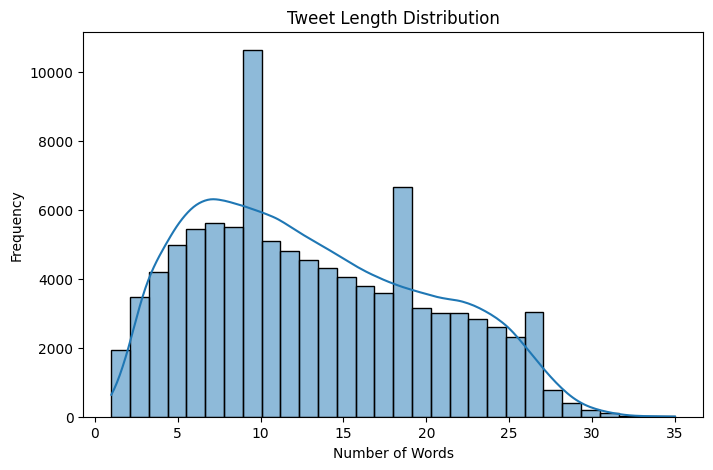

In [ ]:
df["text_length"] = df["tweet"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df["text_length"], bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Tweet Length Distribution Analysis:

*   Most tweets are between 5-25 words
*   Peaks around 10 and 20 words
*   Longest tweets in the dataset reach ~35 words

## Token Length Distribution

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

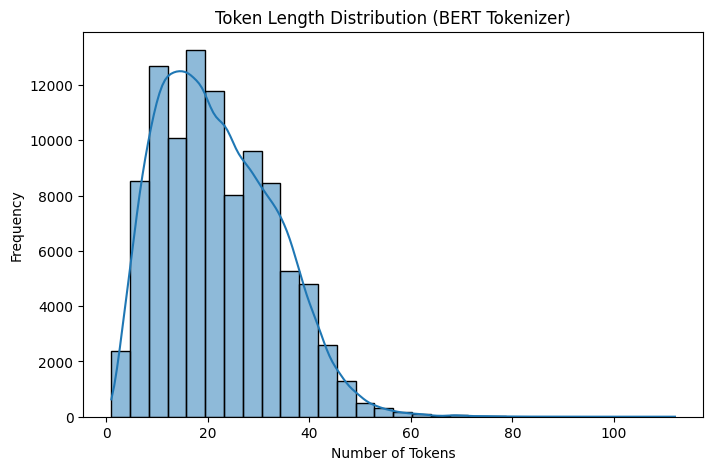

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
df["token_length"] = df["tweet"].apply(lambda x: len(tokenizer.tokenize(x)))
plt.figure(figsize=(8, 5))
sns.histplot(df["token_length"], bins=30, kde=True)
plt.title("Token Length Distribution (BERT Tokenizer)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

Token Length Distribution Analysis:

*   Most tweets fall between 10 to 40 tokens
*   A small number exceed 64 tokens, but very few exceed 100
*   There is a long tail of longer tweets (~70+ tokens), but they are rare

## Word Cloud for Sentiments

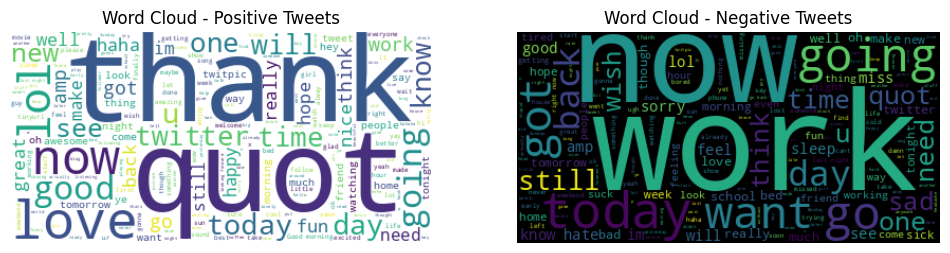

In [ ]:
# Separate positive and negative tweets
positive_text = " ".join(df[df["label"] == 1]["tweet"])
negative_text = " ".join(df[df["label"] == 0]["tweet"])

# Generate word clouds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(background_color="white", max_words=200).generate(positive_text)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Tweets")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(background_color="black", max_words=200).generate(negative_text)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Tweets")

plt.show()

Word Cloud for Sentiments Analysis:

**For Positive Tweets:**

*   Dominant Words:
    *   "thank", "love", "lol", "today", "good", "now"

*   Sentiment Indicators:
    *   "thank" → Expresses gratitude
    *   "love" → Common in positive sentiments
    *   "good" → Directly positive word

*   Potential Noise:
    *   "quot" → An encoding artifact (&quot; from HTML)

**For Negative Tweets:**

*   Dominant Words:
    *   "work", "now", "back", "today", "time", "going", "want", "one"

*   Sentiment Indicators:
    *   "work" and "now" → Could indicate stress or urgency
    *   "back" → Might relate to negative experiences about returning somewhere
    *   "want" → Often appears in complaints or dissatisfaction

*   Potential Noise:
    *   "quot" → Same encoding issue as in positive tweets

## Top Frequent Words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top words in positive tweets: [('-', 2860), ('good', 2614), ('like', 2198), ('love', 2075), ('get', 2070), ('day', 1783), ('going', 1623), ('new', 1427), ('go', 1414), ('got', 1398), ('see', 1380), ('u', 1311), ('time', 1308), ('&amp;', 1274), ('one', 1258), ('know', 1234), ('great', 1206), ('back', 1176), ('think', 1093), ('really', 1013)]
Top words in negative tweets: [('get', 2735), ('go', 2728), ('work', 2581), ('like', 2286), ('back', 2052), ('day', 1912), ('going', 1894), ('got', 1861), ('-', 1730), ('want', 1693), ("can't", 1590), ('really', 1545), ('still', 1509), ('miss', 1334), ('today', 1326), ('time', 1310), ('last', 1305), ('one', 1301), ('im', 1286), ('good', 1226)]


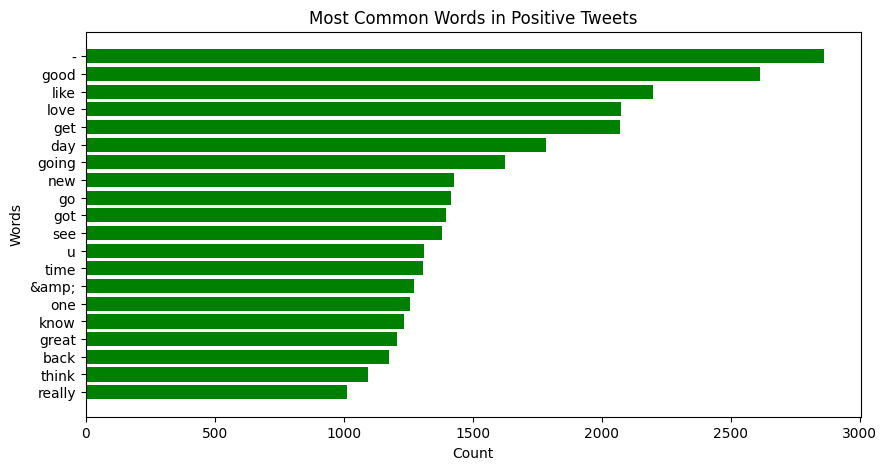

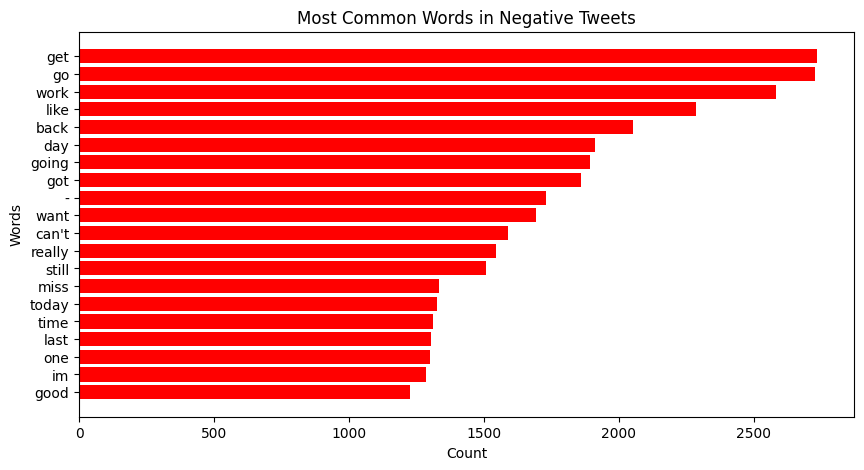

In [ ]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Tokenize and remove stopwords
def get_most_common_words(text_series, n=20):
    words = " ".join(text_series).split()
    words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return Counter(words).most_common(n)

# Get top words for positive and negative tweets
print("Top words in positive tweets:", get_most_common_words(df[df["label"] == 1]["tweet"]))
print("Top words in negative tweets:", get_most_common_words(df[df["label"] == 0]["tweet"]))

# Convert to DataFrame for plotting
pos_words_df = pd.DataFrame(get_most_common_words(df[df["label"] == 1]["tweet"]), columns=["Word", "Count"])
neg_words_df = pd.DataFrame(get_most_common_words(df[df["label"] == 0]["tweet"]), columns=["Word", "Count"])

# Plot Positive Words
plt.figure(figsize=(10,5))
plt.barh(pos_words_df["Word"], pos_words_df["Count"], color="green")
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Most Common Words in Positive Tweets")
plt.gca().invert_yaxis()
plt.show()

# Plot Negative Words
plt.figure(figsize=(10,5))
plt.barh(neg_words_df["Word"], neg_words_df["Count"], color="red")
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Most Common Words in Negative Tweets")
plt.gca().invert_yaxis()
plt.show()

Top Frequent Words Analysis:

*   Potential Issues & Noise
    *   Dash ("-") → Might be an artifact from text splitting
    *   "`&amp;`" → This is an HTML encoding issue (& was not converted properly)

## Special Elements, Misspellings & Slangs Count

In [ ]:
# Initialize spell checker
spell = SpellChecker()

# Define a function to count misspellings accurately
def count_misspellings(text):
    # Remove mentions, URLs, hashtags, HTML entities, and non-word characters
    text = re.sub(r"@\w+|http\S+|www\.\S+|#\w+|&[a-z]+;|\W+", " ", text)
    words = text.lower().split()
    misspelled = spell.unknown(words)
    return len(misspelled)

# Apply function to dataset
df["misspelling_count"] = df["tweet"].apply(count_misspellings)

# Aggregate misspelling count
misspelling_total = df["misspelling_count"].sum()

In [ ]:
# Initialize emot object
emot_obj = emot()

# Define a function to analyze special elements
def analyze_special_elements(text):

    # Extract using emot library
    emoji_result = emot_obj.emoji(text)
    emoticon_result = emot_obj.emoticons(text)

    emoji_count = len(emoji_result['value'])
    emoticon_count = len(emoticon_result['value'])


    mention_count = len(re.findall(r"@\w+", text))  # Mentions (@username)
    hashtag_count = len(re.findall(r"#\w+", text))  # Hashtags (#topic)
    url_count = len(re.findall(r"(http\S+|www\.\S+)", text))  # URLs (http://, https://, www.)
    html_entities_count = len(re.findall(r"&[a-z]+;", text))  # HTML entities like &amp;
    slang_count = len(re.findall(r"\b(u|ur|lol|gr8|lmao|omg|btw|idk|tbh|thx|plz|gonna|wanna)\b", text, re.IGNORECASE))  # Common slang words

    return mention_count, hashtag_count, url_count, emoticon_count, emoji_count, html_entities_count, slang_count

# Apply function to dataset
df[['mention_count', 'hashtag_count', 'url_count', 'emoticon_count', 'emoji_count',
    'html_entities_count', 'slang_count']] = df['tweet'].apply(
    lambda x: pd.Series(analyze_special_elements(str(x)))
)

# Aggregate counts
mention_total = df['mention_count'].sum()
hashtag_total = df['hashtag_count'].sum()
url_total = df['url_count'].sum()
emoticon_total = df['emoticon_count'].sum()
emoji_total = df['emoji_count'].sum()
html_total = df['html_entities_count'].sum()
slang_total = df['slang_count'].sum()

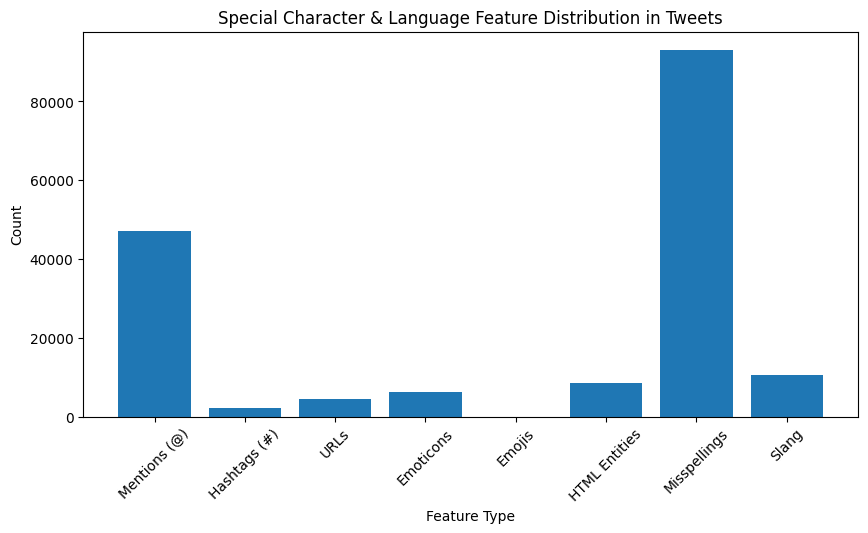

In [ ]:
# Display the distribution of special elements
plt.figure(figsize=(10, 5))
plt.bar(['Mentions (@)', 'Hashtags (#)', 'URLs', 'Emoticons', 'Emojis',
         'HTML Entities', 'Misspellings', 'Slang'],
        [mention_total, hashtag_total, url_total, emoticon_total, emoji_total,
         html_total, misspelling_total, slang_total])

plt.title("Special Character & Language Feature Distribution in Tweets")
plt.xlabel("Feature Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Special Character & Language Feature Distribution in Tweets:

*   Misspellings dominate the chart:
    *   Most frequent feature in the dataset.
    *   This suggests a highly informal tweet collection — possibly from casual users, or tweets that haven’t undergone autocorrection.
    *   Could also include stylized or deliberate misspellings (e.g., “goooood”, “nooo”), or common typos.

*   Mentions (@) are the next most frequent:
    *   High occurrence of @mentions suggests:
        *   Many tweets involve direct interactions (e.g., replies, shoutouts).

*   Slang & HTML Entities
    *   Common slang terms (e.g., “lol”, “idk”) are frequently used — again supporting the informal/casual nature of the data.
    *   HTML entities like "`&amp;`" suggest that data was scraped from raw HTML and wasn't fully normalized before analysis.

*   Emoticons & URLs — Low presence
    *   Emoticons like :-) are more common than emojis in this dataset.
    *   URLs are present, indicating external link sharing, possibly promotional or referencing content.

*   Hashtags — Very low presence
    *   Suggests tweets are less topical or event-driven, or hashtags weren’t used prominently.
    *   Could indicate personal or casual tweet content rather than trend participation.

*   Emojis — Almost nonexistent
    *   This is surprising in modern datasets.
    *   Could be due to:
        *   Emojis removed/lost in preprocessing
        *   Encoding issues